In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
# get input paths
test_set = "miplib_5000_gurobi"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 0, 1]
term_list = [4, 64, 256]
filter_cbc = False

## Check run failures

In [18]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "farkas": [],
    "prlp is primal infeasible": [],  # put outstanding bugs below here
    "must have primalbound > root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "warning": []
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols = {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                count_instances += len([f for f in os.listdir(series_fldr) if
                                        f.endswith(".mps")])
                names[stem] = instance

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    for code in err:
                        if code in text:
                            err[code].append(stem)
                            break
                    else:
                        other.append(stem)

Read MPS format model from file instances/miplib_5000_gurobi/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/10teams.mps
Reading time = 0.00 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/gmu-35-40.mps
Reading time = 0.00 seconds
gmu-35-40: 424 rows, 1205 columns, 4843 nonzeros
Read MPS format model from file instances/miplib_5000_gurobi/neos-3610051-istr

In [19]:
# check which series didn't run
print(no_go)

[]


In [20]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [21]:
# out of time - rerun with more time if a lot of these
print(err["walltime"])
len(err["walltime"]) / count_series

['macrophage_matrix_0_64_New', 'timtab1CUTS_objective_1_64_New', 'timtab1CUTS_objective_0_64_New', 'timtab1CUTS_objective_-1_64_New', 'neos-503737_rhs_0_256_New', 'neos-503737_rhs_0_256_Old', 'neos-503737_rhs_0_256_Farkas', 'neos-503737_objective_1_256_New', 'neos-503737_objective_1_256_Old', 'neos-503737_objective_1_256_Farkas', 'neos-503737_matrix_1_256_New', 'neos-503737_matrix_1_256_Old', 'neos-503737_matrix_1_256_Farkas', 'neos-503737_matrix_0_256_New', 'neos-503737_matrix_0_256_Old', 'neos-503737_matrix_0_256_Farkas', 'neos-503737_objective_0_256_New', 'neos-503737_objective_0_256_Old', 'neos-503737_objective_0_256_Farkas', 'neos-503737_rhs_-1_256_New', 'neos-503737_rhs_-1_256_Old', 'neos-503737_rhs_-1_256_Farkas', 'neos-503737_bound_-1_256_New', 'neos-503737_bound_-1_256_Old', 'neos-503737_bound_-1_256_Farkas', 'neos-503737_matrix_-1_256_New', 'neos-503737_matrix_-1_256_Old', 'neos-503737_matrix_-1_256_Farkas', 'neos-503737_objective_-1_256_New', 'neos-503737_objective_-1_256_Ol

0.04316239316239316

In [22]:
# out of memory - rerun with more memory if a lot of these
print(err["bad_alloc"])
len(err["bad_alloc"]) / count_series

['neos-3610173-itata_rhs_-1_64_Old', 'neos-3610173-itata_rhs_-1_64_Farkas', 'neos-3610051-istra_rhs_-1_64_Old', 'neos-3610051-istra_rhs_-1_64_Farkas', 'neos-585192_matrix_-1_64_Old', 'neos-585192_matrix_-1_64_Farkas', 'neos-3046601-motu_rhs_0_64_Farkas', 'macrophage_matrix_0_64_Old', 'macrophage_matrix_0_64_Farkas', 'neos-574665_objective_1_64_Old', 'neos-574665_objective_1_64_Farkas', 'neos-574665_objective_1_256_New', 'neos-574665_objective_1_256_Old', 'neos-574665_objective_1_256_Farkas', 'neos-574665_matrix_0_256_Old', 'neos-574665_matrix_0_256_Farkas', 'neos-574665_objective_0_64_Old', 'neos-574665_objective_0_64_Farkas', 'neos-574665_objective_0_256_New', 'neos-574665_objective_0_256_Old', 'neos-574665_objective_0_256_Farkas', 'neos-574665_rhs_-1_64_Old', 'neos-574665_rhs_-1_64_Farkas', 'neos-574665_rhs_-1_256_Old', 'neos-574665_rhs_-1_256_Farkas', 'neos-574665_matrix_-1_64_Old', 'neos-574665_matrix_-1_64_Farkas', 'neos-574665_matrix_-1_256_Old', 'neos-574665_matrix_-1_256_Farkas

0.06487179487179487

In [23]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [24]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [25]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

['f2gap801600_bound_1_4_New', 'f2gap801600_bound_1_4_Old', 'f2gap801600_bound_1_4_Farkas', 'neos-585192_bound_1_64_New', 'neos-585192_bound_1_64_Old', 'neos-585192_bound_1_64_Farkas', 'p2756_bound_1_4_New', 'p2756_bound_1_4_Old', 'p2756_bound_1_4_Farkas', 'neos-3118745-obra_bound_1_4_New', 'neos-3118745-obra_bound_1_4_Old', 'neos-3118745-obra_bound_1_4_Farkas', 'nexp-150-20-1-5_bound_1_4_New', 'nexp-150-20-1-5_bound_1_4_Old', 'nexp-150-20-1-5_bound_1_4_Farkas', 'nexp-150-20-1-5_bound_1_64_New', 'nexp-150-20-1-5_bound_1_64_Old', 'nexp-150-20-1-5_bound_1_64_Farkas', 'mod010_bound_1_4_New', 'mod010_bound_1_4_Old', 'mod010_bound_1_4_Farkas', 'f2gap201600_bound_1_4_New', 'f2gap201600_bound_1_4_Old', 'f2gap201600_bound_1_4_Farkas', 'f2gap201600_bound_1_64_New', 'f2gap201600_bound_1_64_Old', 'f2gap201600_bound_1_64_Farkas', 'neos-555884_bound_1_4_New', 'neos-555884_bound_1_4_Old', 'neos-555884_bound_1_4_Farkas', 'neos-3734794-moppy_bound_1_4_New', 'neos-3734794-moppy_bound_1_4_Old', 'neos-373

0.009829059829059829

In [26]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

['f2gap801600_bound_1_4_None', 'f2gap801600_bound_1_64_None', 'f2gap801600_bound_1_256_None', 'neos-585192_bound_1_4_None', 'neos-585192_bound_1_64_None', 'neos-585192_bound_1_256_None', 'neos-555343_bound_1_4_None', 'neos-555343_bound_1_64_None', 'neos-555343_bound_1_256_None', 'neos-503737_bound_1_4_None', 'neos-503737_bound_1_64_None', 'neos-503737_bound_1_256_None', 'p2756_bound_1_4_None', 'p2756_bound_1_64_None', 'p2756_bound_1_256_None', 'neos-3118745-obra_bound_1_4_None', 'neos-3118745-obra_bound_1_64_None', 'neos-3118745-obra_bound_1_256_None', 'nexp-150-20-1-5_bound_1_4_None', 'nexp-150-20-1-5_bound_1_64_None', 'nexp-150-20-1-5_bound_1_256_None', 'mod010_bound_1_4_None', 'mod010_bound_1_64_None', 'mod010_bound_1_256_None', 'fhnw-binpack4-48_bound_1_4_None', 'fhnw-binpack4-48_bound_1_64_None', 'fhnw-binpack4-48_bound_1_256_None', 'neos-1112787_bound_1_4_None', 'neos-1112787_bound_1_64_None', 'neos-1112787_bound_1_256_None', 'app2-2_bound_1_4_None', 'app2-2_bound_1_64_None', 'ap

0.012735042735042735

In [27]:
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_256_term = [n for n in err["no vpcs were made from a new disjunction"] if "_256_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'256 term: {len(missing_256_term) / count_series}')

['bienst2_matrix_1_64_New', 'bienst2_matrix_1_64_Old', 'bienst2_matrix_1_64_Farkas', 'bienst2_matrix_1_256_New', 'bienst2_matrix_1_256_Old', 'bienst2_matrix_1_256_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_matrix_-1_256_New', 'bienst2_matrix_-1_256_Old', 'bienst2_matrix_-1_256_Farkas', 'f2gap801600_objective_1_64_New', 'f2gap801600_objective_1_64_Old', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_objective_1_256_New', 'f2gap801600_objective_1_256_Old', 'f2gap801600_objective_1_256_Farkas', 'f2gap801600_objective_0_64_New', 'f2gap801600_objective_0_64_Old', 'f2gap801600_objective_0_64_Farkas', 'f2gap801600_objective_0_256_New', 'f2gap801600_objective_0_256_Old', 'f2gap801600_objective_0_256_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_objective_-1_64_Farkas', 'f2gap801600_objective_-1_256_New', 'f2gap801600_objective_-1_256_Old', 'f2gap801600_objective_-1_256_Farkas', 'f2gap

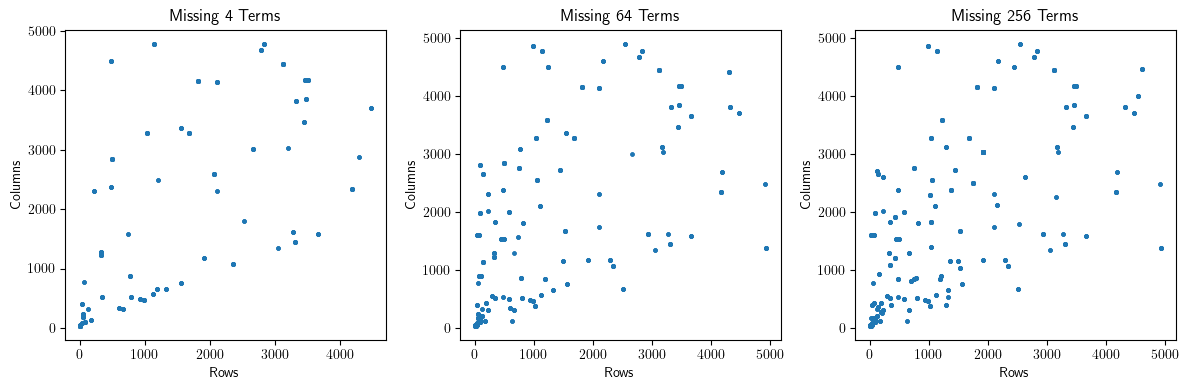

In [30]:
# use latex fonts
plt.rc('text', usetex=True)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot for list_1
axes[0].scatter([rows[names[n]] for n in missing_4_term],
                [cols[names[n]] for n in missing_4_term], s=5)
axes[0].set_title('Missing 4 Terms')
axes[0].set_xlabel('Rows')
axes[0].set_ylabel('Columns')

# Plot for list_2
axes[1].scatter([rows[names[n]] for n in missing_64_term],
                [cols[names[n]] for n in missing_64_term], s=5)
axes[1].set_title('Missing 64 Terms')
axes[1].set_xlabel('Rows')
axes[1].set_ylabel('Columns')

# Plot for list_3
axes[2].scatter([rows[names[n]] for n in missing_256_term],
                [cols[names[n]] for n in missing_256_term], s=5)
axes[2].set_title('Missing 256 Terms')
axes[2].set_xlabel('Rows')
axes[2].set_ylabel('Columns')

# Adjust layout
plt.tight_layout()
plt.show()

In [31]:
# this may be a bug in my code - track down if a lot
print(err["farkas"])
len(err["farkas"]) / count_series

['bienst2_matrix_-1_4_New', 'gmu-35-40_rhs_1_64_New', 'gmu-35-40_rhs_1_64_Old', 'gmu-35-40_rhs_1_64_Farkas', 'gmu-35-40_objective_1_4_New', 'gmu-35-40_objective_1_64_New', 'gmu-35-40_objective_1_64_Old', 'gmu-35-40_objective_1_64_Farkas', 'gmu-35-40_matrix_1_64_New', 'gmu-35-40_matrix_1_64_Old', 'gmu-35-40_matrix_1_64_Farkas', 'gmu-35-40_matrix_0_64_New', 'gmu-35-40_matrix_0_64_Old', 'gmu-35-40_matrix_0_64_Farkas', 'gmu-35-40_rhs_-1_4_New', 'gmu-35-40_rhs_-1_64_New', 'gmu-35-40_rhs_-1_64_Old', 'gmu-35-40_rhs_-1_64_Farkas', 'gmu-35-40_matrix_-1_64_New', 'gmu-35-40_matrix_-1_64_Old', 'gmu-35-40_matrix_-1_64_Farkas', 'gmu-35-40_objective_-1_4_New', 'gmu-35-40_objective_-1_64_New', 'gmu-35-40_objective_-1_64_Old', 'gmu-35-40_objective_-1_64_Farkas', 'gmu-35-40_bound_1_64_New', 'gmu-35-40_bound_1_64_Old', 'gmu-35-40_bound_1_64_Farkas', 'neos-3610051-istra_rhs_-1_4_New', 'neos-585192_matrix_-1_4_New', 'neos-585192_matrix_-1_4_Old', 'neos-585192_matrix_-1_4_Farkas', 'neos-585192_bound_1_4_New

0.02863247863247863

In [32]:
# this shouldn't be an issue - effected runs just get skipped
print(err["prlp is primal infeasible"])
len(err["prlp is primal infeasible"]) / count_series

['neos-3610173-itata_matrix_0_4_Old', 'gmu-35-40_objective_1_4_Old', 'gmu-35-40_matrix_0_4_Old', 'gmu-35-40_rhs_-1_4_Old', 'gmu-35-40_matrix_-1_4_Old', 'gmu-35-40_objective_-1_4_Old', 'neos-3610051-istra_matrix_0_4_New', 'neos-3610051-istra_rhs_-1_4_Old', 'neos-574665_objective_1_4_Old', 'neos-574665_matrix_0_4_Old', 'neos-574665_objective_0_4_Old', 'neos-574665_objective_-1_4_Old', 'aflow40b_matrix_0_4_Old', 'aflow40b_matrix_-1_4_Old', 'aflow40b_objective_-1_4_Old', 'blend2_matrix_-1_4_Old', 'modglob_matrix_-1_4_Old', 'modglob_matrix_-1_64_Old', 'p2756_matrix_1_4_Old', 'p2756_matrix_-1_4_New', 'p2756_matrix_-1_4_Old', 'sp150x300d_matrix_1_4_Old', 'sp150x300d_matrix_1_64_Old', 'sp150x300d_matrix_0_4_Old', 'sp150x300d_matrix_0_64_Old', 'nexp-50-20-1-1_matrix_1_4_Old', 'neos-3118745-obra_rhs_0_4_Old', 'neos-3118745-obra_objective_1_4_Old', 'neos-3118745-obra_matrix_1_4_Old', 'neos-3118745-obra_matrix_0_4_Old', 'neos-3118745-obra_objective_0_4_Old', 'neos-3118745-obra_rhs_-1_4_Old', 'neos

0.020256410256410257

In [33]:
print(err["warning"])
len(err["warning"]) / count_series

['10teams_objective_-1_4_Old', 'neos-574665_objective_0_64_New', 'neos-1396125_matrix_-1_4_New', 'neos-1396125_matrix_-1_4_Old', 'neos-1396125_objective_-1_4_Old', 'dfn-gwin-UUM_matrix_-1_64_Old', 'enigma_matrix_-1_256_New', 'bppc8-09_rhs_0_64_New', 'ns1688347_rhs_-1_4_Old', 'ns1688347_matrix_-1_4_Old', 'neos-3734794-moppy_rhs_1_4_New', 'neos-3734794-moppy_rhs_1_4_Old', 'neos-3734794-moppy_rhs_1_4_Farkas', 'neos-3734794-moppy_objective_1_4_New', 'neos-3734794-moppy_objective_1_4_Old', 'neos-3734794-moppy_objective_1_4_Farkas', 'neos-3734794-moppy_matrix_1_4_Old', 'neos-3734794-moppy_matrix_1_4_Farkas', 'neos-3734794-moppy_rhs_-1_4_New', 'neos-3734794-moppy_rhs_-1_4_Old', 'neos-3734794-moppy_rhs_-1_4_Farkas', 'neos-3734794-moppy_matrix_-1_4_Old', 'neos-3734794-moppy_matrix_-1_4_Farkas', 'neos-3734794-moppy_objective_-1_4_New', 'neos-3734794-moppy_objective_-1_4_Old', 'neos-3734794-moppy_objective_-1_4_Farkas', 'fixnet6_objective_0_256_New', 'fixnet6_objective_-1_256_New', 'neos-631517_o

0.013162393162393163

In [34]:
# issue was not optimizing solver before checking LP relaxation objective vs primal bound
print(err["must have primalbound > root lp objective"])
len(err["must have primalbound > root lp objective"]) / count_series

['neos-1171737_objective_1_4_None', 'neos-1171737_objective_1_64_None', 'neos-1171737_objective_1_256_None', 'neos-1171737_matrix_1_4_None', 'neos-1171737_matrix_1_64_None', 'neos-1171737_matrix_1_256_None', 'neos-1171737_matrix_0_4_None', 'neos-1171737_matrix_0_64_None', 'neos-1171737_matrix_0_256_None', 'neos-1171737_matrix_-1_4_None', 'neos-1171737_matrix_-1_64_None', 'neos-1171737_matrix_-1_256_None', 'neos-1171737_bound_1_4_None', 'neos-1171737_bound_1_64_None', 'neos-1171737_bound_1_256_None', 'neos-3421095-cinca_matrix_-1_4_None', 'neos-3421095-cinca_matrix_-1_64_None', 'neos-3421095-cinca_matrix_-1_256_None', 'neos-1425699_rhs_0_4_None', 'neos-1425699_rhs_0_64_None', 'neos-1425699_rhs_0_256_None', 'neos-5192052-neckar_rhs_0_4_None', 'neos-5192052-neckar_rhs_0_64_None', 'neos-5192052-neckar_rhs_0_256_None', 'neos-5192052-neckar_rhs_1_4_None', 'neos-5192052-neckar_rhs_1_64_None', 'neos-5192052-neckar_rhs_1_256_None', 'neos-5192052-neckar_matrix_1_4_None', 'neos-5192052-neckar_mat

0.019658119658119658

In [35]:
# LP relxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [36]:
# not enough tolerance added to bound (or we hit time limit)
# todo handle this gracefully
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['neos-1425699_rhs_1_4_None', 'neos-1425699_rhs_1_64_None', 'neos-1425699_rhs_1_256_None', 'pp08a_objective_1_4_None', 'pp08a_objective_1_64_None', 'pp08a_objective_1_256_None', 'pp08a_objective_0_4_None', 'pp08a_objective_0_64_None', 'pp08a_objective_0_256_None', 'markshare_4_0_matrix_1_4_None', 'markshare_4_0_matrix_1_64_None', 'markshare_4_0_matrix_1_256_None']


0.0010256410256410256

In [37]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

['neos-3610173-itata_rhs_0_64_New', 'neos-3610173-itata_rhs_1_64_New', 'neos-3610173-itata_matrix_0_64_New', 'neos-3610173-itata_rhs_-1_64_New', 'neos-3610173-itata_matrix_-1_64_New', 'neos-3610051-istra_rhs_0_64_New', 'neos-3610051-istra_rhs_1_4_New', 'neos-3610051-istra_rhs_1_64_New', 'neos-3610051-istra_matrix_0_64_New', 'neos-3610051-istra_rhs_-1_64_New', 'neos-3610051-istra_matrix_-1_64_New', 'neos-585192_matrix_-1_64_New', 'neos-3046601-motu_matrix_1_64_New', 'neos-3046601-motu_matrix_0_64_New', 'neos-3046601-motu_matrix_-1_64_New', 'neos-574665_matrix_0_64_New', 'neos-574665_matrix_0_256_New', 'neos-574665_rhs_-1_64_New', 'neos-574665_rhs_-1_256_New', 'neos-574665_matrix_-1_4_New', 'neos-574665_matrix_-1_64_New', 'neos-574665_matrix_-1_256_New', 'blend2_matrix_-1_64_New', 'blend2_matrix_-1_256_New', 'neos-3611447-jijia_rhs_-1_64_New', 'neos-3611447-jijia_rhs_-1_256_New', 'neos-3611447-jijia_matrix_-1_64_New', 'gesa2_o_rhs_-1_256_New', 'gen-ip036_rhs_0_64_New', 'gen-ip036_rhs_0_2

0.010854700854700855

In [38]:
# this and next issue I think are because we run out of time creating tree leading to errors
# todo: handle gracefully 
print(err["nonbasic reduced cost should be"])
len(err["nonbasic reduced cost should be"]) / count_series

['gmu-35-40_rhs_1_4_New', 'gmu-35-40_rhs_1_4_Old', 'gmu-35-40_rhs_1_4_Farkas', 'gmu-35-40_objective_1_4_Farkas', 'gmu-35-40_matrix_1_4_New', 'gmu-35-40_matrix_1_4_Old', 'gmu-35-40_matrix_1_4_Farkas', 'gmu-35-40_matrix_0_4_New', 'gmu-35-40_matrix_0_4_Farkas', 'gmu-35-40_rhs_-1_4_Farkas', 'gmu-35-40_matrix_-1_4_New', 'gmu-35-40_matrix_-1_4_Farkas', 'gmu-35-40_objective_-1_4_Farkas', 'gmu-35-40_bound_1_4_New', 'gmu-35-40_bound_1_4_Old', 'gmu-35-40_bound_1_4_Farkas', 'neos-3610051-istra_matrix_-1_64_Old', 'neos-3611447-jijia_matrix_-1_4_New', 'neos-3611447-jijia_matrix_-1_64_Old', 'sp150x300d_rhs_0_4_New', 'sp150x300d_rhs_0_4_Old', 'sp150x300d_rhs_0_4_Farkas', 'sp150x300d_rhs_0_64_New', 'sp150x300d_rhs_0_64_Old', 'sp150x300d_rhs_0_64_Farkas', 'sp150x300d_rhs_0_256_New', 'sp150x300d_rhs_0_256_Old', 'sp150x300d_rhs_0_256_Farkas', 'sp150x300d_rhs_1_4_New', 'sp150x300d_rhs_1_4_Old', 'sp150x300d_rhs_1_4_Farkas', 'sp150x300d_rhs_1_64_New', 'sp150x300d_rhs_1_64_Old', 'sp150x300d_rhs_1_64_Farkas',

0.006495726495726496

In [39]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

['ns1208400_matrix_-1_64_New', 'ns1208400_matrix_-1_64_Old', 'ns1208400_matrix_-1_64_Farkas', 'ns1208400_matrix_-1_256_New', 'ns1208400_matrix_-1_256_Old', 'ns1208400_matrix_-1_256_Farkas', 'neos-691058_rhs_1_64_New', 'neos-691058_rhs_1_64_Old', 'neos-691058_rhs_1_64_Farkas', 'neos-691058_rhs_1_256_New', 'neos-691058_rhs_1_256_Old', 'neos-691058_rhs_1_256_Farkas', 'neos-691058_objective_1_64_New', 'neos-691058_objective_1_64_Old', 'neos-691058_objective_1_64_Farkas', 'neos-691058_objective_1_256_New', 'neos-691058_objective_1_256_Farkas', 'neos-691058_matrix_1_64_New', 'neos-691058_matrix_1_64_Old', 'neos-691058_matrix_1_64_Farkas', 'neos-691058_matrix_1_256_New', 'neos-691058_matrix_1_256_Old', 'neos-691058_matrix_1_256_Farkas', 'neos-691058_matrix_-1_64_New', 'neos-691058_matrix_-1_64_Old', 'neos-691058_matrix_-1_64_Farkas', 'neos-691058_objective_-1_64_New', 'neos-691058_objective_-1_64_Old', 'neos-691058_objective_-1_64_Farkas', 'neos-691058_objective_-1_256_New', 'neos-691058_obje

0.014017094017094018

In [40]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [41]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [42]:
# errors unaccounted for
print(other)
len(other) / count_series

['neos-3610173-itata_matrix_-1_64_Old', 'neos-3046601-motu_rhs_0_64_Old', 'supportcase20_matrix_-1_256_Farkas', 'gr4x6_matrix_0_4_New', 'neos5_rhs_1_256_Farkas', 'neos5_matrix_1_256_Farkas', 'icir97_tension_rhs_1_64_Old', 'app3_matrix_-1_256_New', 'app3_matrix_-1_256_Old', 'app3_matrix_-1_256_Farkas', 'app3_objective_-1_256_New', 'app3_objective_-1_256_Old', 'app3_objective_-1_256_Farkas', 'eil33-2_objective_1_4_New', 'neos16_rhs_0_4_New', 'neos16_rhs_0_4_Old', 'neos16_rhs_0_4_Farkas', 'neos16_rhs_1_4_New', 'neos16_rhs_1_4_Old', 'neos16_rhs_1_4_Farkas', 'neos16_matrix_1_4_New', 'neos16_matrix_0_4_New', 'neos16_matrix_-1_4_New', 'neos16_matrix_-1_4_Old', 'tr12-30_matrix_0_256_Farkas', 'neos-585467_matrix_-1_4_Farkas', 'gesa3_o_objective_0_256_Farkas', 'neos-807639_matrix_1_64_New', 'neos-807639_matrix_1_64_Old', 'neos-807639_matrix_1_64_Farkas', 'neos-807639_rhs_-1_4_New', 'neos-807639_rhs_-1_64_New', 'neos-807639_rhs_-1_64_Old', 'neos-807639_rhs_-1_64_Farkas', 'neos-807639_matrix_-1_4_

0.0035042735042735045

In [43]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["walltime"])) / count_series

0.10803418803418803

## Read in data

In [44]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "primalBound": float,
    "rootDualBound": float
}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = match.group(1)
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])

In [45]:
# get proportion of instances run
for generator, df in df_map.items():
    print(f"{generator}: {4 * len(df) / count_instances}")

None: 0.9165759006010731
Farkas: 0.3451934325708984
New: 0.3457985396748558
Old: 0.3082012182823026


In [46]:
gen = "Farkas" # make sure masks 3 and 9 are fixed rest should be fine
masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"],
        2: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"],
        3: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"],
        4: df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"],
        5: df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"],
        6: df_map[gen]["primalBound"] > 1e20,
        7: 0 > df_map[gen]["vpcGenerationTime"],
        8: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"],
        9: df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"],
        10: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"],
        11: df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"],
        12: df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20
    }

df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,iterations,maxTime,actualTerms,numCuts,cutLimit,mipSolver,providePrimalBound,instance,perturbation,degree


In [47]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"]) | \
        (df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"]) | \
        (df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"]) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20)
    df_map[gen] = df_map[gen][~mask]

In [48]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,bestSolutionTime Farkas,terminationTime Farkas,nodes Farkas,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas
0,0,None,4,128.750000,128.750000,128.750000,131.526798,134.500000,134.500000,0.000003,...,178.128003,182.206371,1890,235889,300.0,4,3,124,GUROBI,1
1,0,None,4,128.750000,128.750000,128.750000,131.526798,134.500000,134.500000,0.000004,...,178.732566,182.975171,1890,235889,300.0,4,3,124,GUROBI,1
2,0,None,4,2327.842584,2327.842584,2327.842584,2328.327296,2353.796131,2361.454195,0.000004,...,88.709302,300.000582,1319966,5277186,300.0,4,15,20,GUROBI,1
3,1,None,4,2324.771540,2324.771540,2324.771540,2326.295949,2351.438836,2357.655430,0.000004,...,11.475952,300.000584,1307219,5234939,300.0,4,15,0,GUROBI,1
4,0,None,4,23.260000,23.260000,23.260000,23.260000,54.760000,54.760000,0.000002,...,300.001603,300.001773,302054,3479071,300.0,4,48,48,GUROBI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,8,None,4,3470.622000,3470.622000,3470.622000,4090.107024,4191.000000,4191.000000,0.000002,...,0.548989,0.555203,11,1394,300.0,4,12,0,GUROBI,1
5023,9,None,4,88.314000,88.314000,88.314000,676.600626,758.000000,758.000000,0.000002,...,0.495301,0.503787,25,1069,300.0,4,12,0,GUROBI,1
5024,0,None,256,3892.000000,3892.000000,3892.000000,3932.893204,3941.622378,3942.000000,0.000003,...,87.073045,89.074960,5639,121092,300.0,256,4,119,GUROBI,1
5025,1,None,256,3930.000000,3930.000000,3930.000000,3970.172414,3992.184211,3992.583333,0.000003,...,7.663229,7.778678,2273,32613,300.0,256,4,0,GUROBI,1


In [49]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.20279156077292348

In [50]:
def gap_closed(df, col):
    gap = (df[col] - df["lpBound None"]) / (df['primalBound None'] - df["lpBound None"])
    gap[(gap < 0) | (gap > 1)] = np.nan
    return gap

In [51]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = (df["Root Cuts (Farkas)"] - df["Root Cuts (None)"]) / df["Root Cuts (None)"] 
df = df.dropna()

In [52]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37171/2524607786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc None"] = df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37171/2524607786.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_37171/2524607786.py:4: SettingWithCopyWarni

In [53]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [54]:
# get rid of instances that solved trivially quickly
mean_run = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) &
                              (optimality_gap(df_map["None"]) <= 1e-4)].groupby("instance")["terminationTime"].mean().to_dict()
toss = [instance for instance, time in mean_run.items() if time < 1]
df = df.loc[~df["instance"].isin(toss)]

In [55]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
0,0,None,4,128.750000,128.750000,128.750000,131.526798,134.500000,134.500000,0.000003,...,3.856672,3.805074,3.863066,65.235223,89.549618,90.153734,89.679210,-1.626761e+00,-0.395864,-0.347052
1,0,None,4,128.750000,128.750000,128.750000,131.526798,134.500000,134.500000,0.000004,...,3.881176,3.830868,3.856392,66.758884,91.522325,90.720787,91.671716,-1.582219e+00,-0.395864,-0.347052
2,0,None,4,2327.842584,2327.842584,2327.842584,2328.327296,2353.796131,2361.454195,0.000004,...,0.042732,0.043487,0.044041,299.955048,299.227629,299.203000,299.249622,1.866663e-07,-0.043790,-0.001701
3,1,None,4,2324.771540,2324.771540,2324.771540,2326.295949,2351.438836,2357.655430,0.000004,...,0.042807,0.044379,0.041581,299.964377,299.017522,299.804228,299.924086,1.601305e-05,-0.018362,0.003922
5,1,None,4,0.000000,0.000000,0.000000,23.072000,47.160000,47.170000,0.000002,...,0.191756,0.189311,0.215386,14.890472,15.748506,14.839196,14.892313,-1.644511e-02,0.215385,0.110407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,8,None,4,106.385399,106.385399,106.385399,120.709197,123.000000,125.000000,0.000002,...,0.145063,0.159199,0.149155,0.069727,0.080090,0.082230,0.080967,-5.961616e-01,-0.056738,-0.093593
5016,9,None,4,103.433226,103.433226,103.433226,114.524568,120.000000,120.000000,0.000002,...,0.182402,0.192873,0.186008,0.499965,0.826588,1.296324,0.847330,-6.610265e-01,-0.619529,-0.563762
5024,0,None,256,3892.000000,3892.000000,3892.000000,3932.893204,3941.622378,3942.000000,0.000003,...,0.225380,0.209662,0.211302,10.386792,13.512252,13.135977,13.224449,-7.402296e+00,0.210003,-0.190105
5025,1,None,256,3930.000000,3930.000000,3930.000000,3970.172414,3992.184211,3992.583333,0.000003,...,0.202202,0.184597,0.189485,4.197960,3.501120,4.574611,3.496684,-7.591420e-01,0.199648,0.208403


In [56]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip 0th indexed runs and runs where VPC finds the opimal solution
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999) 

## Make bound table

In [57]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
3,gen-ip021,rhs,1.0,4,1,0.031492,0.022400,0.031492,0.018945,0.006418,0.046357,0.043556,0.039324,0.046357
5,neos-911880,matrix,0.5,4,1,0.488808,0.000000,0.000000,0.000000,0.000000,0.489124,0.489124,0.489124,0.489124
6,neos-911880,matrix,0.5,4,6,0.204335,0.000000,0.000000,0.000000,0.000000,0.943725,0.923332,0.946052,0.923332
7,neos-911880,matrix,0.5,4,9,0.406169,0.000000,0.000000,0.000000,0.000000,0.803110,0.794423,0.800958,0.791756
18,neos-595904,objective,0.5,4,1,0.022082,0.022082,0.011608,0.022082,0.022082,0.972695,0.977108,0.977902,0.977409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5014,neos-3611689-kaihu,matrix,0.5,4,7,0.077519,0.072340,0.025591,0.022560,0.005742,0.821999,0.821999,0.821999,0.821999
5015,neos-3611689-kaihu,matrix,0.5,4,8,0.107754,0.001190,0.055567,0.000245,0.000000,0.769493,0.769493,0.769493,0.769493
5016,neos-3611689-kaihu,matrix,0.5,4,9,0.059641,0.005066,0.000716,0.003871,0.002133,0.669493,0.669493,0.672370,0.669493
5025,tension,matrix,0.5,256,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.641903,0.641903,0.641903,0.641903


In [58]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [60]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,instanceIndex
0,0.5,4,0.087573,0.038369,0.040767,0.027875,0.024456,0.707298,0.709694,0.709895,0.708680,84,1289
1,0.5,64,0.189354,0.129352,0.084582,0.074339,0.066401,0.774610,0.776193,0.776348,0.775506,40,518
2,0.5,256,0.302632,0.223257,0.156457,0.150484,0.131788,0.739943,0.743816,0.741876,0.743357,18,148
3,1.0,4,0.083617,0.032958,0.036106,0.024279,0.019783,0.788214,0.787304,0.788297,0.787431,43,475
4,1.0,64,0.227254,0.104443,0.064739,0.050603,0.039788,0.829881,0.830299,0.830223,0.829689,17,156
5,1.0,256,0.334199,0.206682,0.122850,0.095319,0.077929,0.856292,0.857563,0.856311,0.858881,6,45
6,2.0,4,0.096541,0.039563,0.039956,0.027724,0.023791,0.674943,0.679602,0.678818,0.677672,36,394
7,2.0,64,0.306952,0.134468,0.125346,0.094280,0.083584,0.653799,0.680998,0.677012,0.673468,18,134
8,2.0,256,0.387352,0.271802,0.194739,0.188859,0.165615,0.544791,0.610716,0.605161,0.592074,8,33


In [61]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.097029           0.032450    0.045335   
             objective              0.044942           0.043120    0.032661   
             rhs                    0.140221           0.039248    0.046935   
       64    matrix                 0.131903           0.117082    0.079499   
             objective              0.166769           0.149782    0.094402   
             rhs                    0.289053           0.115812    0.077101   
       256   matrix                 0.214976           0.197259    0.165331   
             objective              0.312786           0.282451    0.207007   
             rhs                    0.373939           0.183637    0.093450   
1.0    4     matrix                 0.067298           0.033380    0.043868   
             objective              0.045239           0.036464    0.033563   
             rhs                    0.196844           0.024192    0.030566   
       64    matrix                 0.112461           0.072914    0.063684   
             objective              0.177396           0.142342    0.083710   
             rhs                    0.436788           0.072649    0.033017   
       256   matrix                 0.070513           0.142366    0.051985   
             objective              0.333199           0.263974    0.183357   
             rhs                    0.600384           0.127769    0.042448   
2.0    4     matrix                 0.090466           0.038529    0.050830   
             objective              0.051960           0.043129    0.037694   
             rhs                    0.198436           0.033249    0.031610   
       64    matrix                 0.264885           0.133069    0.173233   
             objective              0.237200           0.150464    0.109814   
             rhs                    0.396183           0.122290    0.102275   
       256   matrix                 0.223454           0.233623    0.205700   
             objective              0.405862           0.358218    0.183423   
             rhs                    0.516158           0.212236    0.197120   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.025071       0.020283          0.742148   
             objective       0.030120       0.027854          0.705162   
             rhs             0.028299       0.025002          0.662250   
       64    matrix          0.069821       0.056184          0.770956   
             objective       0.083219       0.077701          0.783140   
             rhs             0.067482       0.063003          0.767203   
       256   matrix          0.155069       0.117935          0.728641   
             objective       0.173913       0.165082          0.747396   
             rhs             0.120840       0.108780          0.742491   
1.0    4     matrix          0.023876       0.016903          0.801156   
             objective       0.026906       0.022634          0.766547   
             rhs             0.018770       0.017404          0.819462   
       64    matrix          0.042119       0.013203          0.904710   
             objective       0.073788       0.069135          0.751101   
             rhs             0.019560       0.017499          0.885999   
       256   matrix          0.048591       0.025441          0.938218   
             objective       0.142482       0.118823          0.779250   
             rhs             0.024140       0.028181          0.966971   
2.0    4     matrix          0.029317       0.023377          0.669727   
             objective       0.026836       0.023248          0.654452   
             rhs             0.027681       0.025443          0.724705   
       64    matrix          0.11

## Make Profiles

In [62]:
def make_plots(prof_df, metric, dim=3, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }

    # Create subplots for a 3x3 grid
    fig, axes = plt.subplots(dim, dim, figsize=(dim*4, dim*4))
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    if dim == 2:
        unique_degrees = unique_degrees[1:]
        unique_terms = unique_terms[1:]
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 300,
                "terminationTimeSansVpc": 300,
                "terminationTime": 300,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 100,
                "iterations": 500
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= 1e-4")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(-0.05, 1.05)
    
    if dim == 3:
        fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                     f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                     f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                     f'{"perturbing only " + perturbation if perturbation else ""}'
                     f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                     fontsize=16)
    else:
        fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                     f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                     f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                     f'{"perturbing only " + perturbation if perturbation else ""}'
                     f'{"(top " + str(int((1 - threshold) * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                     fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}_{dim}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [63]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
       (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4)  # only check the ones that solve to optimality
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,48.473537,41.771708,36.168047,35.856233,35.609231,36.337020,35.913283,35.856233,...,34.943492,35.665771,35.247505,35.206689,12.864306,5.434689,0.254764,-0.151689,80,915
1,0.5,64,119.923662,71.790482,44.439166,39.408357,41.464840,42.138880,41.975361,39.408357,...,41.046045,41.720099,41.552854,38.991243,78.458821,29.651602,2.463805,-2.157189,39,363
2,0.5,256,138.976958,68.507772,34.164125,25.701206,26.865664,27.208911,29.119902,25.701206,...,26.590489,26.937047,28.840522,25.432158,112.111293,41.298861,5.044223,-11.164936,18,83
3,1.0,4,30.373837,23.050827,18.836886,19.594521,18.827229,18.835484,18.623562,19.594521,...,18.239595,18.243731,18.027458,18.991074,11.546608,4.215343,0.213324,-0.155522,37,319
4,1.0,64,63.257506,47.675915,28.918476,26.624759,25.402770,25.020362,26.023979,26.624759,...,25.073443,24.686880,25.679115,26.273566,37.854736,22.655553,2.894498,-4.100827,15,123
5,1.0,256,92.802413,33.681152,12.572583,10.604136,7.988113,9.511756,7.036116,10.604136,...,7.779717,9.305225,6.827072,10.391478,84.814300,24.169395,5.536466,-15.573158,6,36
6,2.0,4,35.271662,27.794251,19.356081,19.145480,19.444767,18.379192,19.068861,19.145480,...,18.828976,17.770237,18.454457,18.558705,15.826895,9.415059,0.287220,-0.252712,30,304
7,2.0,64,62.249293,61.576775,13.315115,8.372056,7.599786,9.744853,9.104791,8.372056,...,7.182980,9.332747,8.688064,7.970305,54.649507,51.831922,4.210324,-5.174968,13,94
8,2.0,256,82.426328,27.548966,16.379713,12.308785,10.689802,13.198202,9.864288,12.308785,...,10.401746,13.012975,9.699963,12.128336,71.736526,14.350764,6.515424,-18.744200,4,14


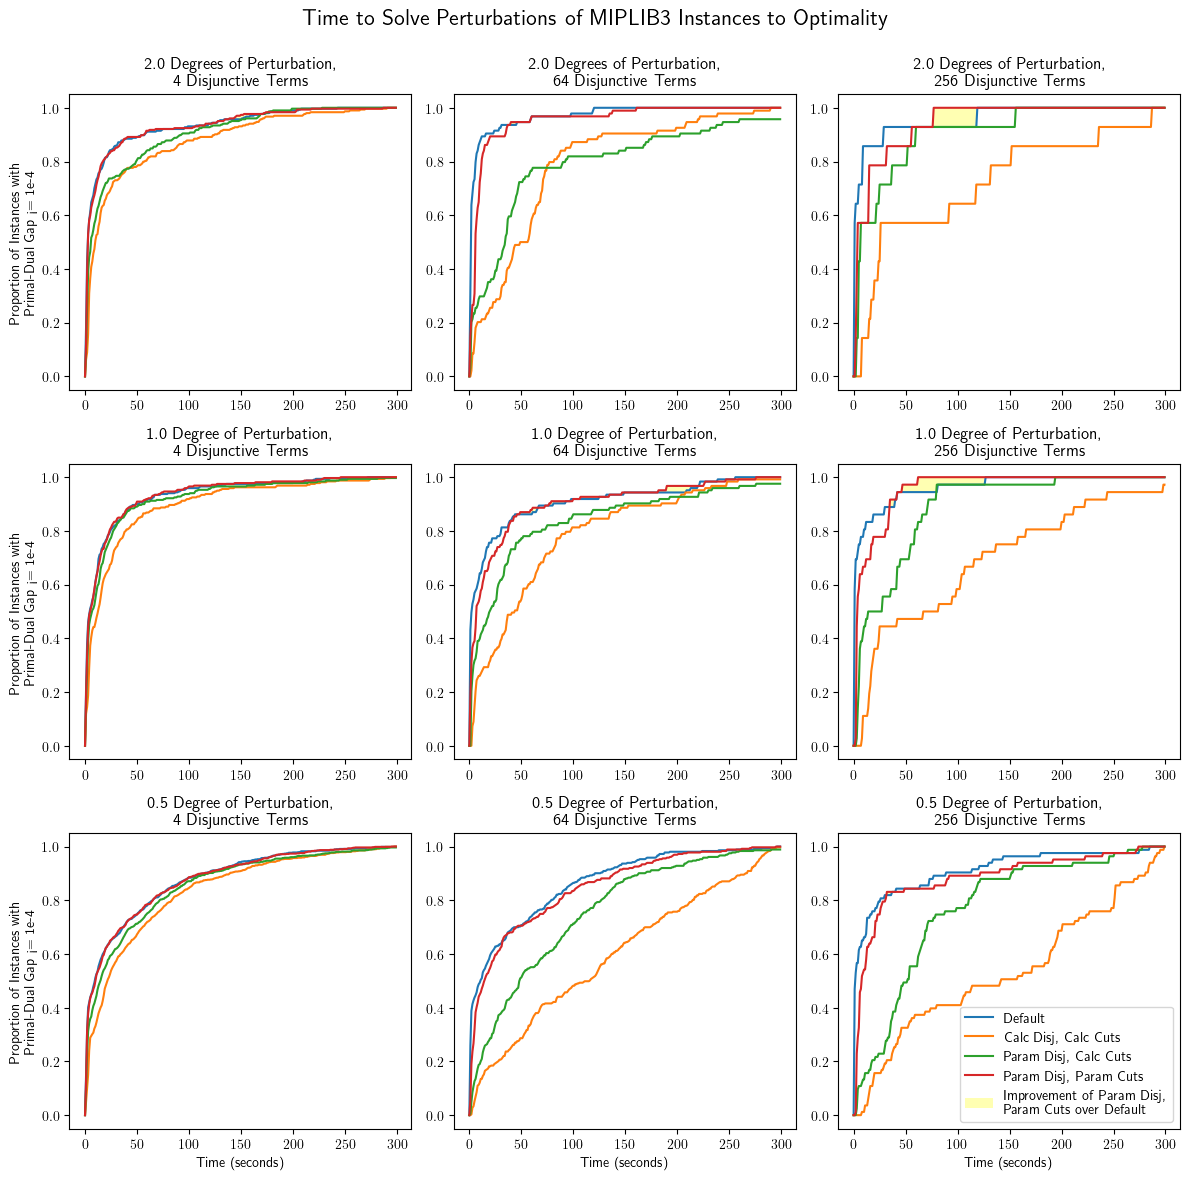

In [65]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [66]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,17.130765,17.660821,16.577613,16.884861,-0.000152,80,915
1,0.5,64,16.662733,19.091631,17.673284,19.836482,-0.002157,39,363
2,0.5,256,11.533530,13.745181,12.536241,11.815373,-0.011165,18,83
3,1.0,4,6.838414,7.335740,6.749150,7.029398,-0.000156,37,319
4,1.0,64,7.252439,7.503220,7.427301,7.683528,-0.004101,15,123
5,1.0,256,3.807361,4.305000,3.659972,4.215778,-0.015573,6,36
6,2.0,4,4.548161,4.528181,4.667691,4.548789,-0.000253,30,304
7,2.0,64,2.014426,2.255872,2.362287,2.282723,-0.005175,13,94
8,2.0,256,3.058357,3.757143,3.233786,3.012143,-0.018744,4,14


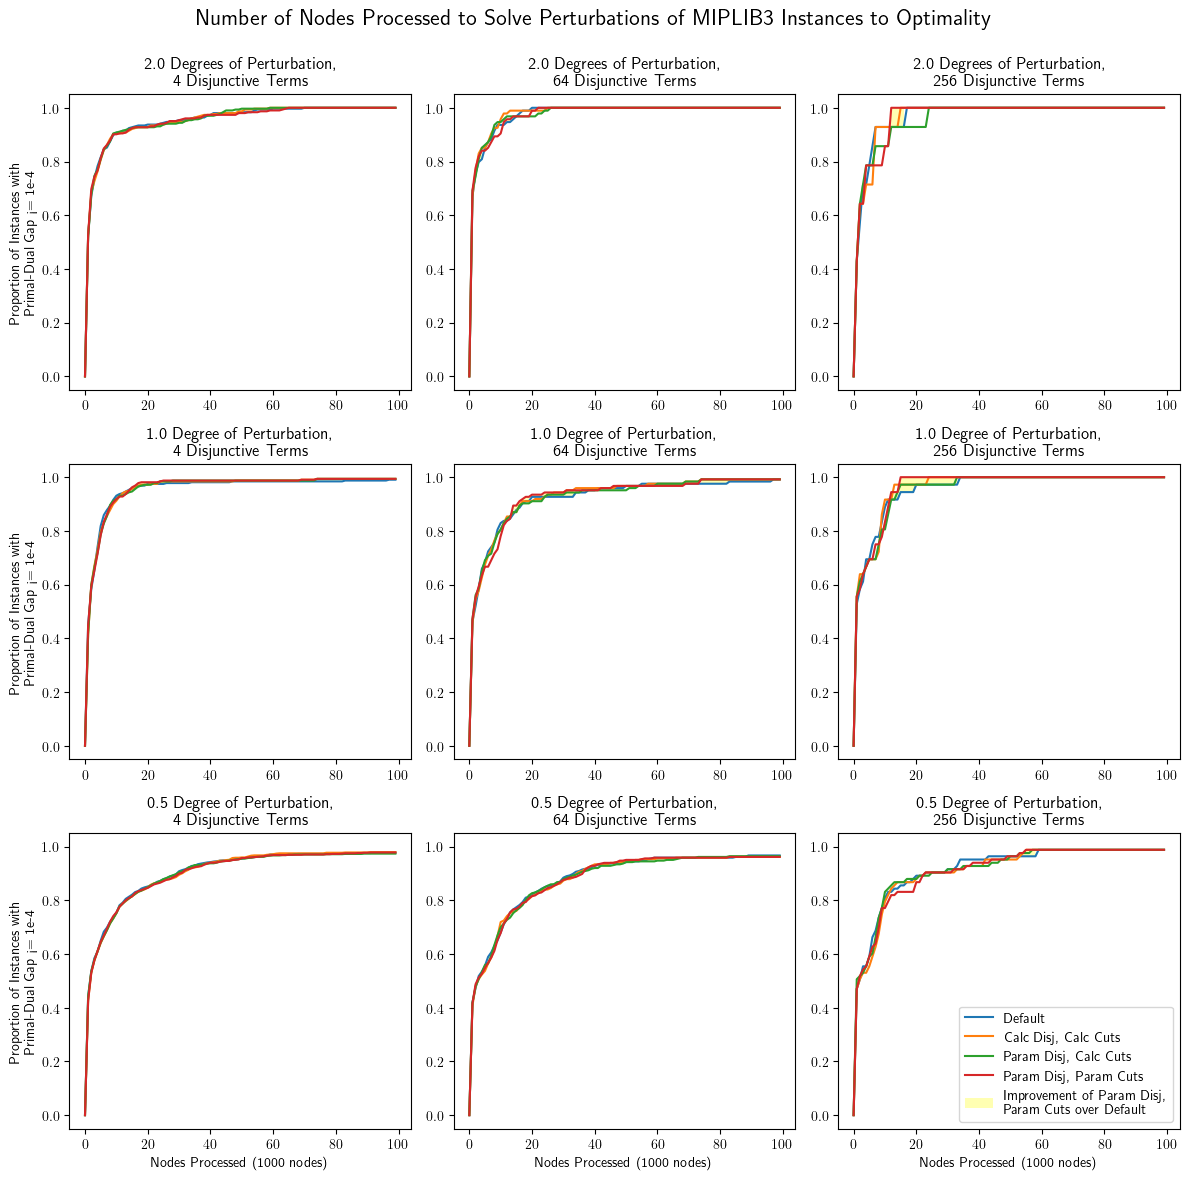

In [67]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [68]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,249.534668,256.207726,250.240380,248.005803,-0.000152,80,915
1,0.5,64,309.418873,323.874865,317.167667,314.042300,-0.002157,39,363
2,0.5,256,224.612313,236.069169,233.254072,209.548795,-0.011165,18,83
3,1.0,4,98.577517,96.506047,95.760009,94.986614,-0.000156,37,319
4,1.0,64,134.863626,129.810268,138.489748,145.932512,-0.004101,15,123
5,1.0,256,43.098194,49.952806,44.156972,59.559528,-0.015573,6,36
6,2.0,4,125.126477,123.341299,123.532217,122.276793,-0.000253,30,304
7,2.0,64,43.479798,54.399798,51.906968,47.650734,-0.005175,13,94
8,2.0,256,60.349357,81.158786,59.987786,70.556929,-0.018744,4,14


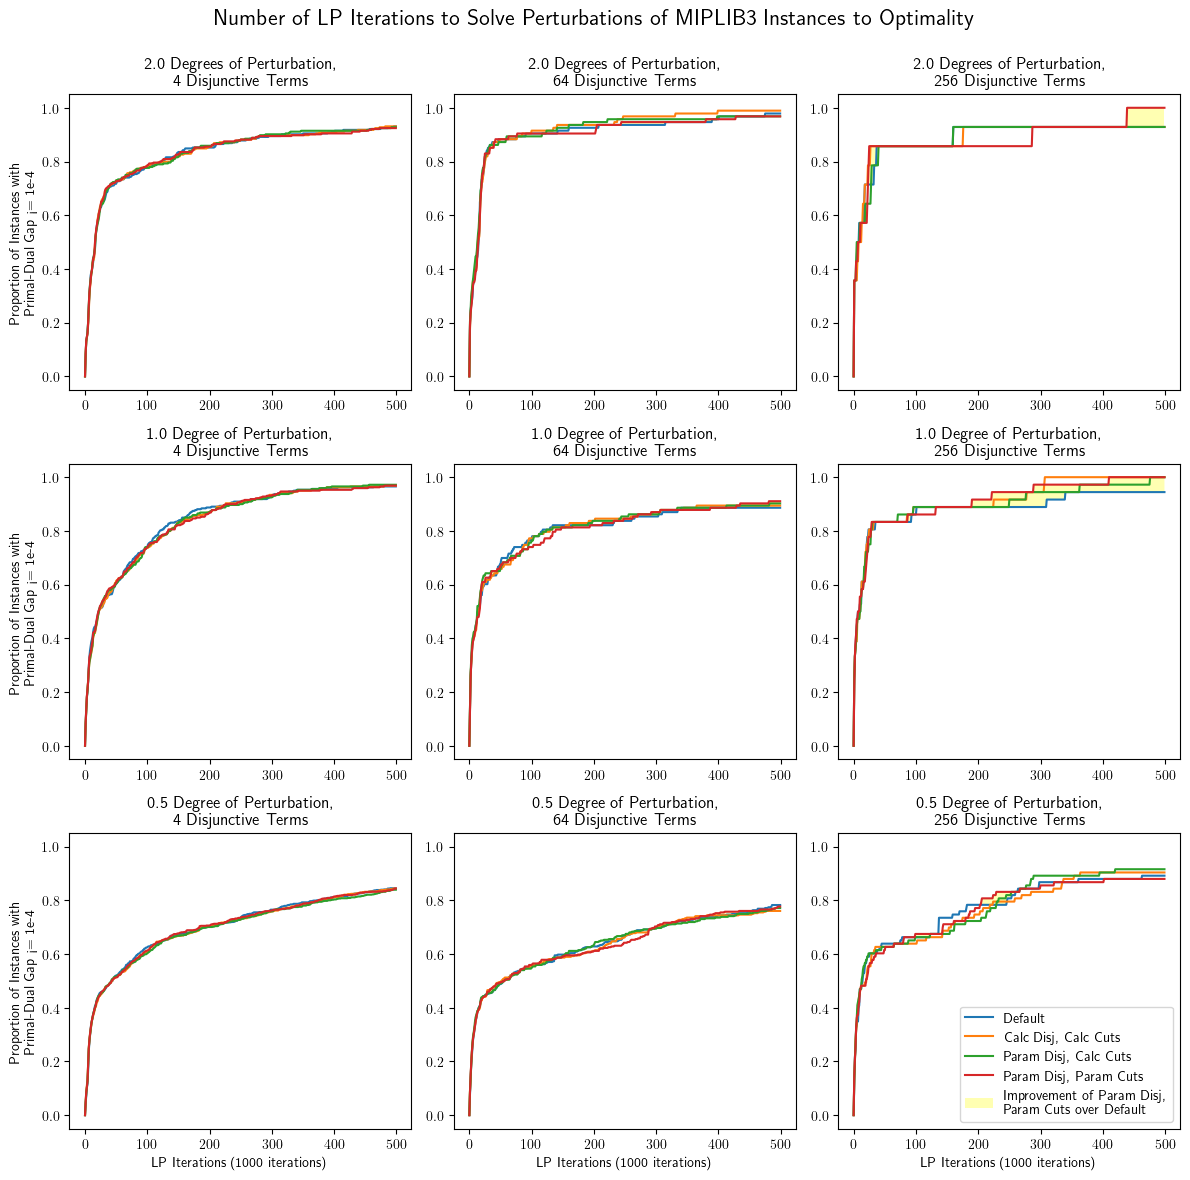

In [69]:
make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [70]:
def make_run_time_boxplot(time_df, perturbation=None, threshold=.1):
    plt.rc('text', usetex=True)  # use latex fonts

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(nrows=len(terms), ncols=len(degrees), figsize=(8*len(terms), 4*len(degrees)))
    
    # Iterate through each combination of degree and terms
    for i, degree in enumerate(degrees):
        for j, term in enumerate(terms):
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            axes[i, j].boxplot(instance_data, labels=unique_instances)
            axes[i, j].axhline(cut_off, color='black', linestyle='--', linewidth=1, alpha=.5, label=f"Top {int(threshold * 100)} Percent of Instances")
            axes[i, j].set_ylim(-3, 1)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_title(f"{degree} Degree{'s' if degree >= 2 else ''} "
                                 f"of Perturbation,\n{term} Disjunctive Terms")
            if j == 0:
                axes[i, j].set_ylabel('Relative Time Improvement\n'
                                      '(Param Disj, Param Cuts vs Default)')
            if i == len(degrees) - 1:
                axes[i, j].set_xlabel('Instance')
    
    fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                 f"Param Cuts compared to Default"
                 f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                 f"(positive values imply Param Disj, Param Cuts'"
                 f" run time faster than Default's)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution"
                                       f"{'_' + perturbation if perturbation else ''}.png"),
                dpi=1200)
    plt.legend()
    plt.show()

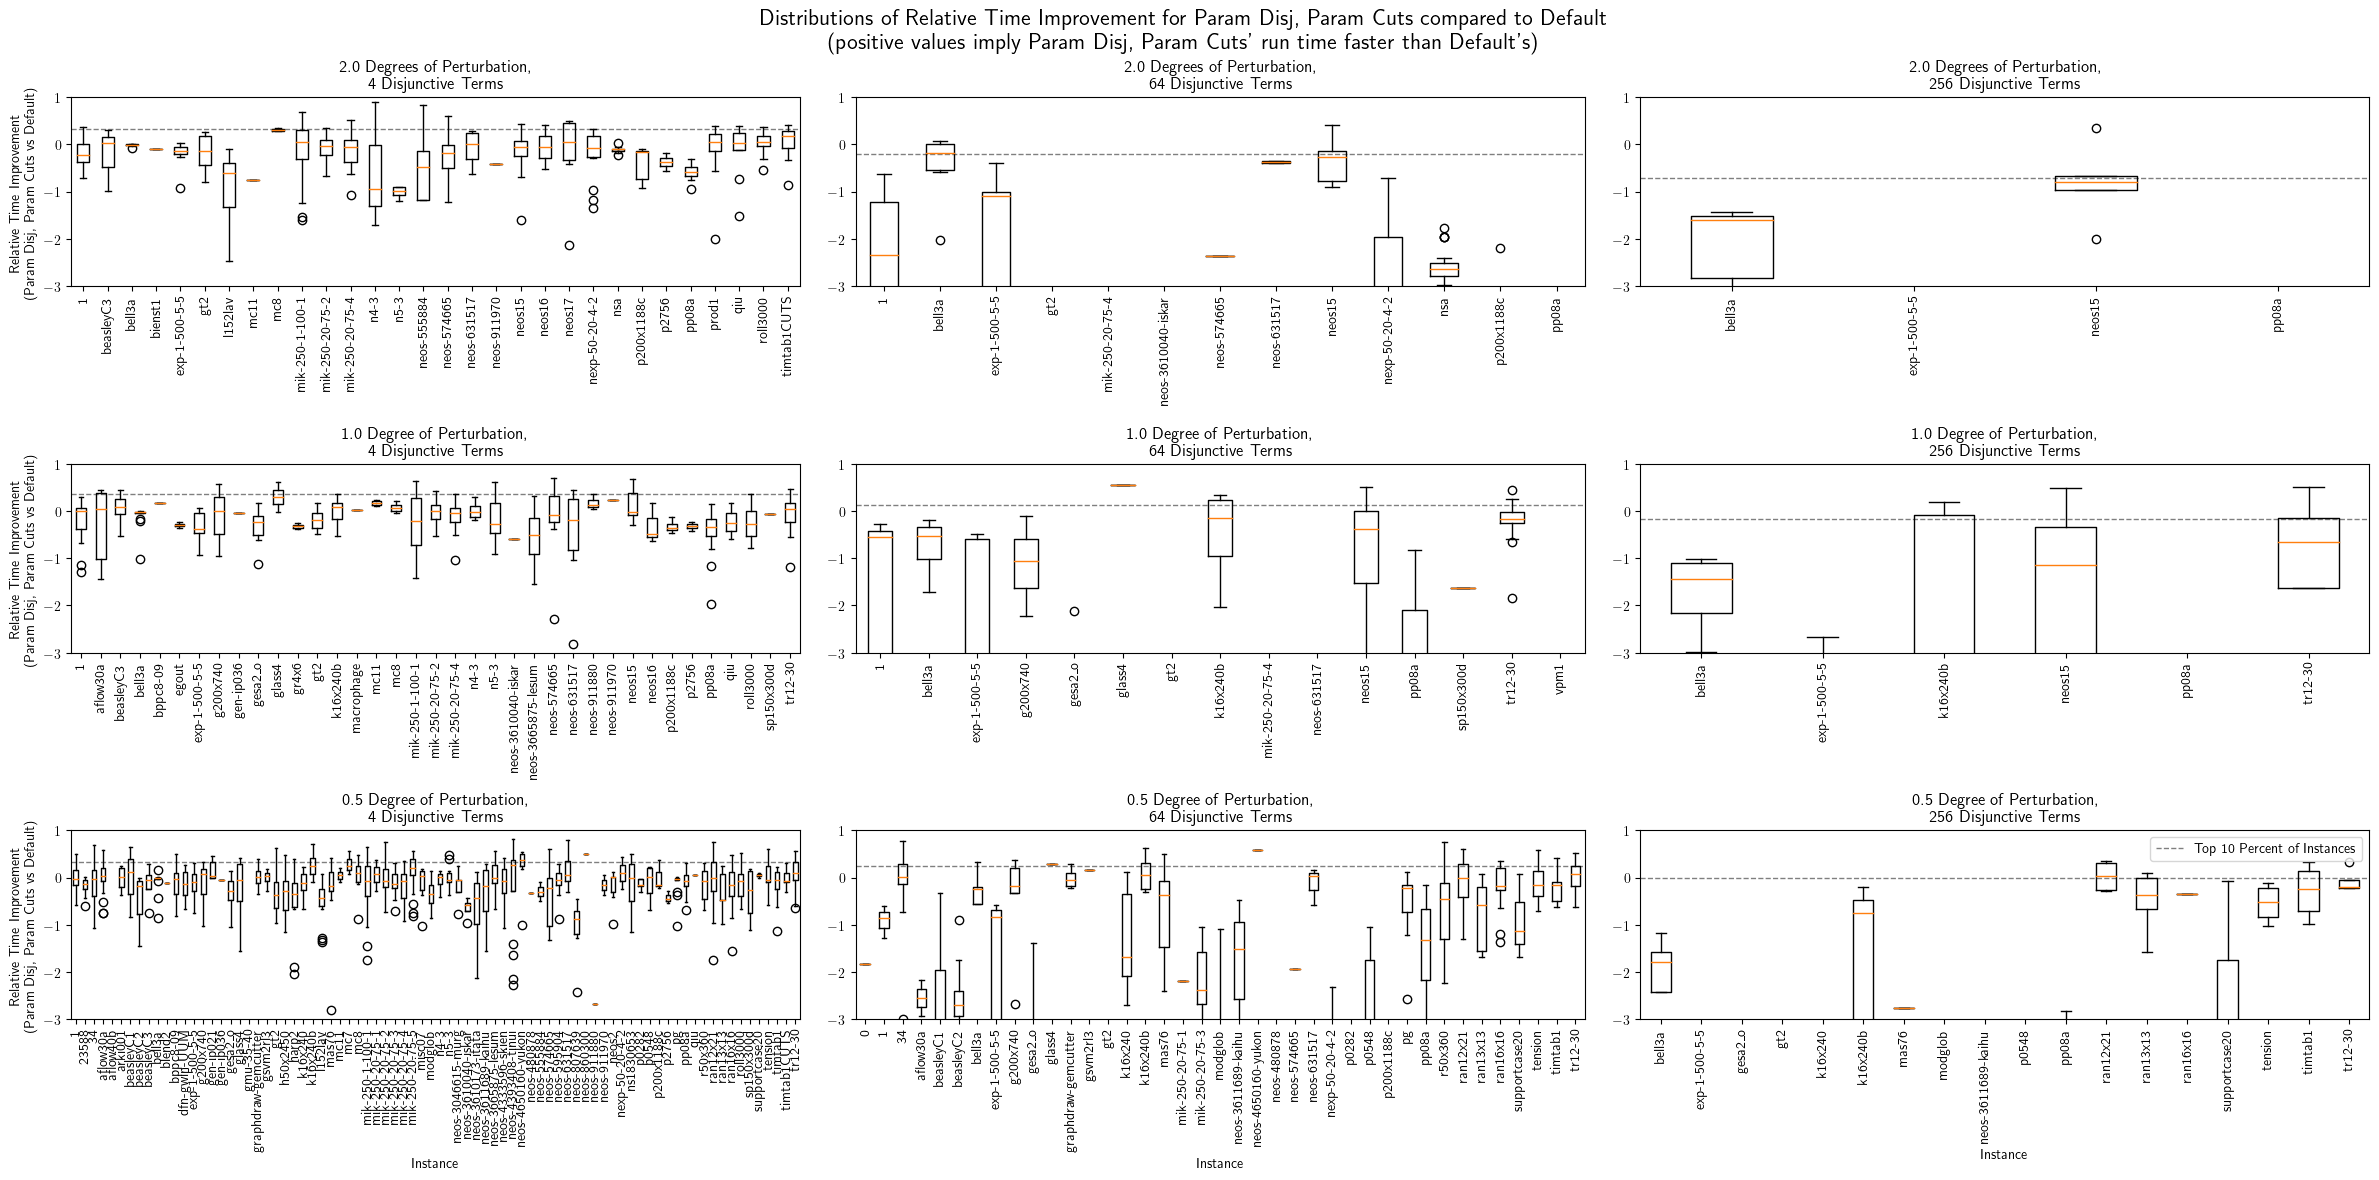

In [71]:
make_run_time_boxplot(time_df)

In [72]:
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


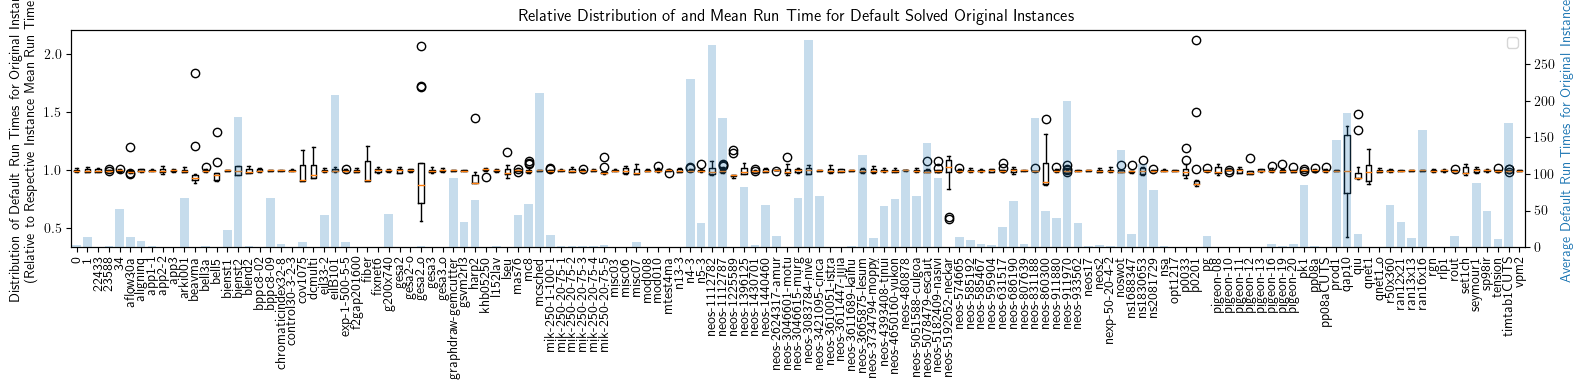

In [74]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times for Original Instances\n'
               '(Relative to Respective Instance Mean Run Time)')
ax1.set_title("Relative Distribution of and Mean Run Time for Default Solved Original Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [75]:
gap_df = df.loc[mask]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [76]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

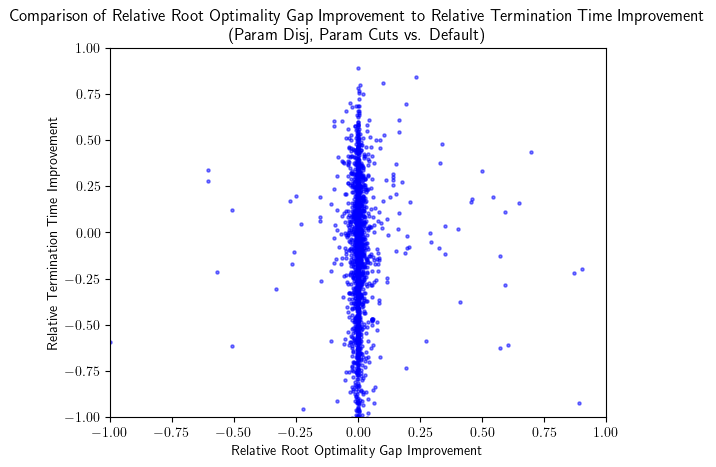

In [77]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Relative Root Optimality Gap Improvement to Relative Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination Time Improvement")
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

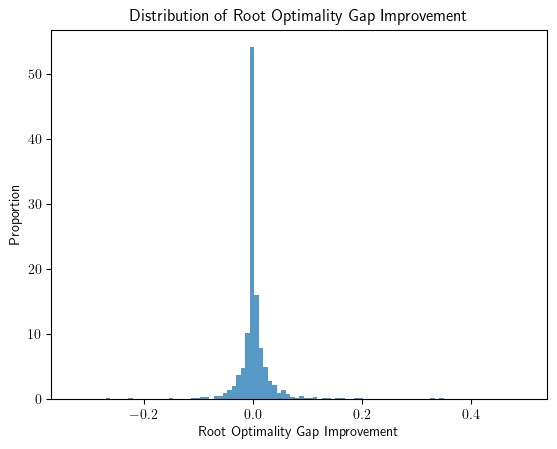

In [78]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

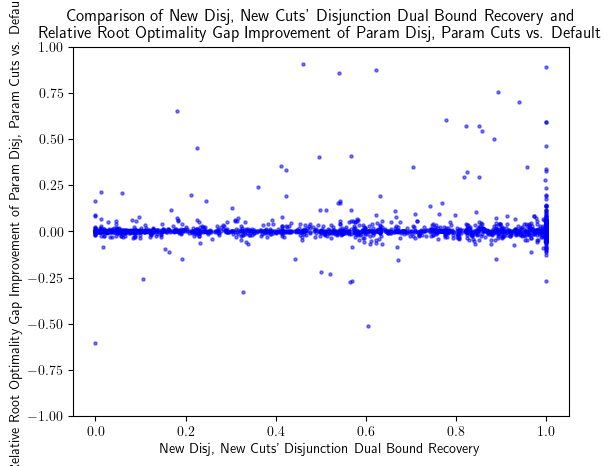

In [79]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.show()

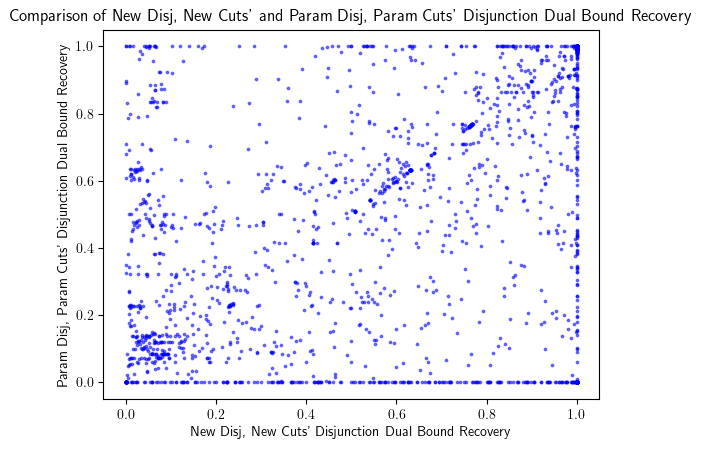

In [80]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [81]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

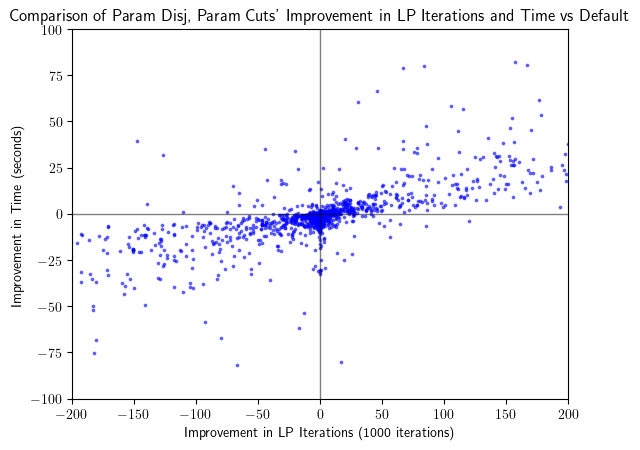

In [82]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

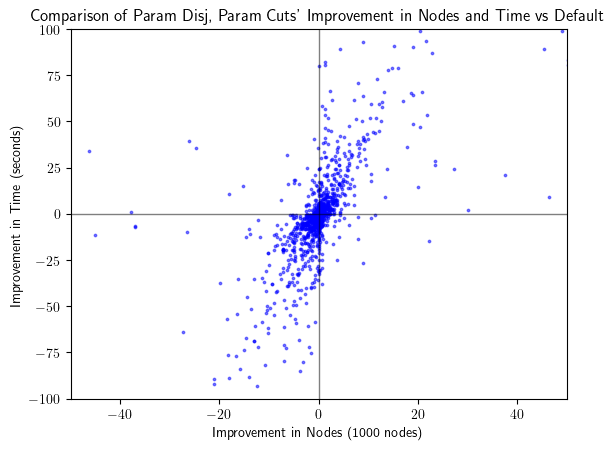

In [83]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

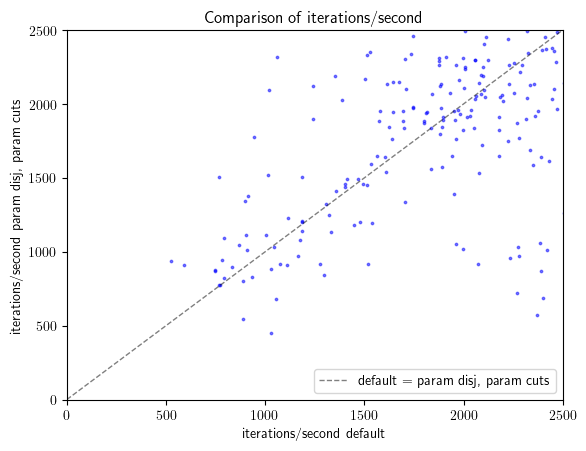

In [84]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

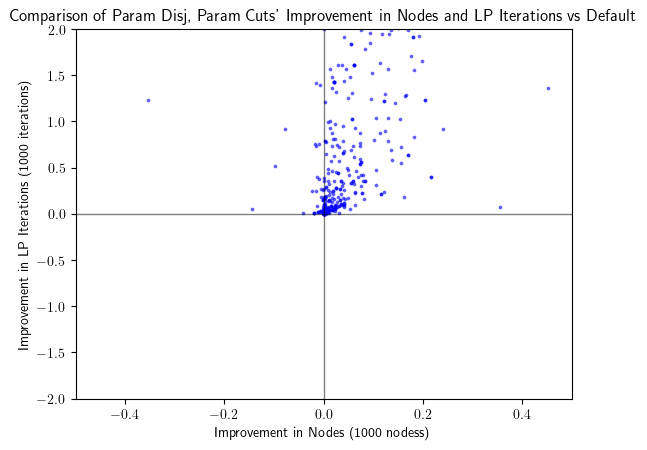

In [85]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

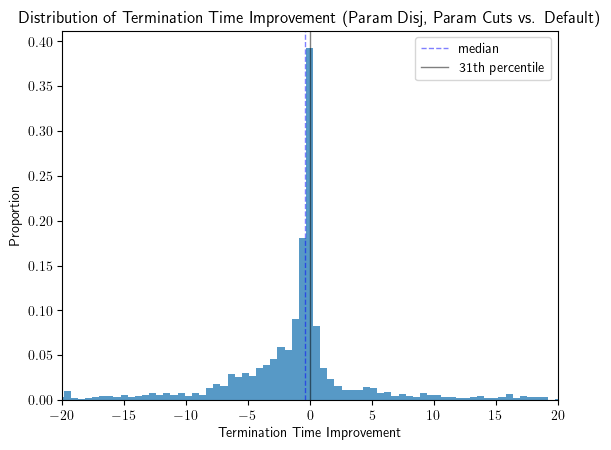

In [86]:
# Create a histogram with 600 bins
plt.hist(gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
         bins=600, density=True, alpha=0.75)
plt.xlim(-20, 20)

cut_off = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('Termination Time Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Termination Time Improvement (Param Disj, Param Cuts vs. Default)')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

In [87]:
gap_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
6,6,None,4,0.000000,0.000000,0.000000,46.412379,49.180000,49.180000,0.000003,...,0.936399,1.083335,0.957512,45.487356,49.080058,254.036825,169.379020,-2.667282,-2.932716,-2.599872
18,1,None,4,60025.327763,60025.327763,60025.327763,64533.507146,64654.392756,64660.057500,0.000004,...,1.974563,1.846736,1.640455,2.481468,1.848006,2.152493,2.019881,0.066432,0.318339,0.222305
19,2,None,4,60213.709157,60213.709157,60213.709157,64723.231527,64836.429930,64842.190000,0.000004,...,1.429974,1.417284,1.599291,2.568822,2.370744,2.488599,1.557391,0.164784,0.217021,0.363110
20,3,None,4,60215.898590,60215.898590,60215.898590,64819.035800,64931.432000,64931.432000,0.000003,...,2.004939,1.774048,1.947612,0.906827,3.007393,1.351908,2.928784,-0.877252,-3.306667,-1.710174
21,4,None,4,60177.320826,60177.320826,60177.320826,64670.965935,64789.189793,64793.916000,0.000004,...,1.770966,1.737522,1.411186,1.582705,2.176231,0.785723,2.363941,-0.338384,-0.524096,-0.387560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011,4,None,4,103.391549,103.391549,103.391549,113.622632,120.000000,120.000000,0.000002,...,0.169934,0.132566,0.127435,1.359688,1.922117,1.665273,2.640978,-0.865129,-0.268231,-0.272258
5012,5,None,4,106.626960,106.626960,106.626960,121.532947,126.000000,126.000000,0.000004,...,0.200967,0.221925,0.189365,0.878779,0.825940,0.668854,1.812200,-0.965568,-0.300699,-0.142203
5016,9,None,4,103.433226,103.433226,103.433226,114.524568,120.000000,120.000000,0.000002,...,0.182402,0.192873,0.186008,0.499965,0.826588,1.296324,0.847330,-0.661026,-0.619529,-0.563762
5025,1,None,256,3930.000000,3930.000000,3930.000000,3970.172414,3992.184211,3992.583333,0.000003,...,0.202202,0.184597,0.189485,4.197960,3.501120,4.574611,3.496684,-0.759142,0.199648,0.208403


In [71]:
gap_df[gap_df]

ValueError: Boolean array expected for the condition, not int64

In [98]:
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None", "rootDualBound New"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp["my ratio"] = comp["rootDualBound New"] / comp["rootDualBound None"]
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,my ratio
0,1,4,6637.188027,6641.585617,6640.550919,6714.074468,6716.532958,1.000366
1,23588,4,7649.866134,7799.912563,7774.120220,7770.367871,7797.326487,1.003469
2,34,4,-16646.586017,-16604.076548,-16632.927170,-14367.516589,-14367.400780,0.999992
3,34,64,-16646.586017,-16491.988398,-16628.141847,-14367.516589,-14367.000168,0.999964
4,aflow30a,4,983.167425,996.971374,992.433003,1097.314305,1094.229840,0.997189
...,...,...,...,...,...,...,...,...
122,timtab1,256,28694.000000,132337.666667,58255.000000,454731.502967,468703.993029,1.030727
123,timtab1CUTS,4,618783.684884,623532.408286,620946.155756,632895.730479,631604.389869,0.997960
124,tr12-30,4,25302.209524,25611.359565,25498.481331,129146.721533,129090.840776,0.999567
125,tr12-30,64,25302.209524,27137.949884,25721.798427,129146.721533,129090.840776,0.999567


In [112]:
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS"]]
adf.columns = groups + fields
adf["aleks ratio"] = adf["rootDualBound New"] / adf["rootDualBound None"]
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,aleks ratio
0,22433,2.0,2.124053e+04,21314.98074,2.131206e+04,2.141369e+04,2.140756e+04,0.999713
1,23588,2.0,7.649866e+03,7746.197749,7.726713e+03,7.757177e+03,7.789200e+03,1.004128
2,10teams,2.0,9.170000e+02,917,9.170000e+02,9.240000e+02,9.240000e+02,1.000000
3,30n20b8,2.0,1.241230e+02,124.2095421,1.241823e+02,1.542021e+02,1.528972e+02,0.991538
4,50v-10,2.0,2.879066e+03,2884.065687,2.884066e+03,3.195241e+03,3.199688e+03,1.001392
...,...,...,...,...,...,...,...,...
2637,vpm1,64.0,1.643333e+01,16.71111111,1.660000e+01,1.886429e+01,1.900595e+01,1.007510
2638,vpm2,64.0,1.113563e+01,11.5093094,1.134045e+01,1.305095e+01,1.305186e+01,1.000070
2639,wachplan,64.0,-9.000000e+00,-9,NaN,0.000000e+00,0.000000e+00,NaN
2640,zib54-UUE,64.0,4.330388e+06,5389605.005,4.850439e+06,8.432754e+06,8.397464e+06,0.995815


In [117]:
# join comp and adf on instance and terms
diff = comp[groups + ["my ratio"]].merge(adf[groups + ["aleks ratio"]], on=groups)
diff[np.abs(diff["my ratio"] - diff["aleks ratio"]) > .02]

,instance,terms,my ratio,aleks ratio
23,gsvm2rl3,4,1.509963,1.065242
24,gsvm2rl3,64,1.267143,1.099603
75,ns1830653,4,0.945378,1.011150
93,supportcase20,4,0.975189,1.003421
95,timtab1,4,1.019303,0.991444
96,timtab1,64,1.015229,0.978402


In [120]:
diff[diff.columns[1:]].groupby("terms").mean()

,my ratio,aleks ratio
terms,,
4,1.007317,1.001713
64,1.010598,1.005017


In [121]:
adf[["terms", "aleks ratio"]].groupby("terms").mean()

,aleks ratio
terms,
2.0,1.227926
4.0,1.218641
8.0,1.231829
16.0,1.240385
32.0,1.263117
64.0,1.034405


In [122]:
count_instances

99156